# Imports

In [1]:
from ultralytics import YOLO
import os
from azure.storage.blob import BlobServiceClient
from pydicom import dcmread
from io import BytesIO
import numpy as np
import cv2
import pylidc as pl
import matplotlib.pyplot as plt

# Helper Functions

## Return ann from slice

In [2]:
# Return annotations
def get_ann_from_slice(patient_id, slice_location):
    # Fetch the scan for the patient
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
    if not scan:
        raise ValueError(f"No scan found for patient ID {patient_id}")

    # Initialize list to store annotations
    annotations = []

    # Iterate over all annotations in the scan
    for ann in scan.annotations:
        for contour in ann.contours:
            # Check if the annotation is close to the specified slice location
            if abs(contour.image_z_position - slice_location) < scan.slice_spacing:
                annotations.append(ann)
                break

    return annotations

## Returns if model result is positive

In [3]:
def isNodule(result):
    return len(result.boxes.xywh.tolist()) > 0

## Draws BBoxes (pred and label) on sample images and saves in outpath

In [4]:
def draw_boxes(outpath, name, result, ann):
    image = result.orig_img
    
    for box in result.boxes.xywh:
        x_center, y_center, width, height = box.tolist()

        # x1 = int(x_center - width / 2)
        # y1 = int(y_center - height / 2)
        # x2 = int(x_center + width / 2)
        # y2 = int(y_center + height / 2)
        
        cv2.circle(image, (int(x_center), int(y_center)), 15, (0, 255, 0), 2)
        
        # cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    if len(ann) > 0:
        # x_all = []
        # y_all = []
        for a in ann:
            x, y, z = a.centroid
            # x_all.append(int(x))
            # y_all.append(int(y))
            cv2.circle(image, (int(y), int(x)), 25, (0, 0, 255), 2)
        # cv2.circle(image, (int(np.mean(y_all)), int(np.mean(x_all))), 15, (0, 0, 255), 2)
        
    cv2.imwrite(f'{outpath}/{name}.jpg', image)

## Returns range of contiguous slices (we include one-apart slices to account for YOLO error)

In [5]:
def get_contiguous_slice(i, arr):
    while i >= 0 and (arr[i-1] == arr[i]-1 or arr[i-1] == arr[i]-2):
        i -= 1
    start = i
    while i < len(arr)-1 and (arr[i+1] == arr[i]+1 or arr[i+1] == arr[i]+2):
        i += 1
    return range(arr[start], arr[i])

## Returns range of contiguous slices looking based on bbox

In [6]:
def get_contiguous_box(i, arr):
    prev = arr[i-1]
    curr = arr[i]
    next = arr[i+1]
    
    while i >= 0 and (arr[i-1] == arr[i]-1 or arr[i-1] == arr[i]-2):
        i -= 1
    start = i
    while i < len(arr)-1 and (arr[i+1] == arr[i]+1 or arr[i+1] == arr[i]+2):
        i += 1
    return range(arr[start], arr[i])

## Adds bounding box center x and y to boxes[]

In [7]:
def getBoundingBox(result):
    boxes = []
    for coords in result.boxes.xywh.tolist():
        x = int(coords[0])
        y = int(coords[1])
        w = int(coords[2])
        h = int(coords[3])
        boxes.append([x, y, w, h])
    return boxes

## Returns true if two bounding boxes are referring to the same nodule

In [8]:
def same_box(box1, box2):
    threshold = 10
    return (abs(box1[0] - box2[0]) < threshold and
            abs(box1[1] - box2[1]) < threshold and
            abs(box1[2] - box2[2]) < threshold and
            abs(box1[3] - box2[3]) < threshold)

## Functions for identifying 3D nodules

In [9]:
# Returns if two bounding boxes are the same
def compare_boxes(box1, box2):
    thresh = 15
    return (abs(box1[0]-box2[0]) < thresh and
            abs(box1[1]-box2[1]) < thresh and
            abs(box1[2]-box2[2]) < thresh and
            abs(box1[3]-box2[3]) < thresh)

# Returns if a slice contains a box similar to the reference box
def check_slice_for_box(slice, ref):
    for box in slice:
        if compare_boxes(box, ref):
            return True
    return False

# Checks for one-apart slices
def first_slice_one_apart(index, boxes, ref):
    if index > 0:
        return check_slice_for_box(boxes[index-1], ref)
    return False

# Checks for one-apart slices
def last_slice_one_apart(index, boxes, ref):
    if index < len(boxes)-1:
        return check_slice_for_box(boxes[index+1], ref)
    return False

# Returns index of first slice with a matching box
def get_first_slice(index, boxes, ref):
    while index >= 0:
        if check_slice_for_box(boxes[index], ref):
            index -= 1
        elif first_slice_one_apart(index, boxes, ref):
            index -= 2
        else:
            break
    return index+1

# Returns index of last slice with a matching box
def get_last_slice(index, boxes, ref):
    while index < len(boxes):
        if check_slice_for_box(boxes[index], ref):
            index += 1
        elif last_slice_one_apart(index, boxes, ref):
            index += 2
        else:
            break
    return index-1

# Returns number of slices that contain a box similar to the reference box
def get_num_slices(index, boxes, ref):
    first = get_first_slice(index-1, boxes, ref)
    last = get_last_slice(index+1, boxes, ref)
    return last-first+1

# Returns the max number of contiguous slices that has a matching box
def get_num_relevant_slices(index, boxes):
    max = 0
    for box in boxes[index]:
        num = get_num_slices(index, boxes, box)
        if num > max:
            max = num
    return max

# Generate Results

## Create arrays that store image_paths (for model) and annotations

In [10]:
path = '/home/andrew/ITRI-LungCancer/sample/'
imgs = os.listdir(path)
imgs.sort()

model_input = []
annotations = []
for i, img in enumerate(imgs):
    patient_id = img.split('_')[0]
    slice_location = float(img.split('_')[-1].split('.')[0])
    
    annotations.append(get_ann_from_slice(patient_id, slice_location))
    model_input.append(path+img)

## Recreate dirs

In [11]:
!rm -rf /home/andrew/ITRI-LungCancer/sample_out
!mkdir -p /home/andrew/ITRI-LungCancer/sample_out

## Draw bboxes on imags and save to outpath
## Create anns and outs arrays that store which slices have annotations

In [12]:
outpath = '/home/andrew/ITRI-LungCancer/sample_out/'

anns = []
outputs = []
boxes = []

model = YOLO('/home/andrew/ITRI-LungCancer/YOLO/model_slimjim.pt')

for path, ann in zip(model_input, annotations):
    result = model(path, verbose=False, conf=0.3, iou=0.0, augment=True)[0]
    slice_num = int(path.split('_')[1])
    box = []

    has_annotation = False
    if isNodule(result):
        has_annotation = True
        
    outputs.append(slice_num)
    boxes.append(getBoundingBox(result))

    if len(ann) > 0:
        anns.append(slice_num)
        has_annotation = True

    if has_annotation:
        draw_boxes(outpath, path.split('_')[-2], result, ann)

In [19]:
# Filter out slices with less than 5 contiguous slices
print(outputs)
outs = []
for i, slice in enumerate(outputs):
    if get_num_relevant_slices(i, boxes) >= 5:
        outs.append(slice)
print(outs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

/tmp/ipykernel_97394/857986973.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


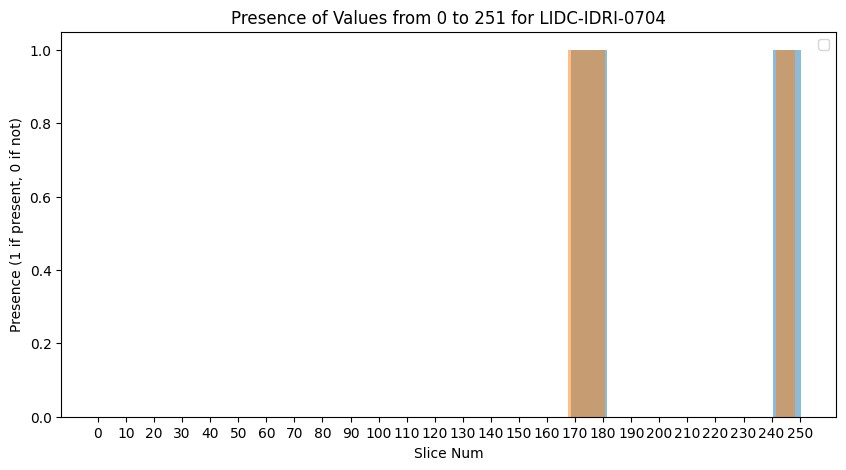

In [20]:
# Determines max y value to show on graph
y_max = max(anns[-1], outs[-1]) + 1

# Create an array of zeros for the range 0-200
presence = [0] * y_max
presence2 = [0] * y_max

# Mark presence of each value in the list
for value in anns:
    presence[value] = 1
    
for value in outs:
    presence2[value] = 1

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(y_max), presence, width=1.0, alpha=.5)
plt.bar(range(y_max), presence2, width=1.0, alpha=.5)
plt.xlabel('Slice Num')
plt.ylabel('Presence (1 if present, 0 if not)')
patient_id = path.split('_')[0].split('/')[-1]
plt.title(f'Presence of Values from 0 to {y_max} for {patient_id}')
plt.xticks(range(0, y_max, 10))
plt.legend()

plt.show()